## Text Classification with a Feedforward Network

The project performed as an Assignment in Natural Language Processing course at the University of Sheffield.
The data is a subset of the [AG News Corpus](http://groups.di.unipi.it/~gulli/AG_corpus_of_news_articles.html)

#### Roadmap:

- Text processing methods for transforming raw text data into input vectors 
- A Feedforward network consisting of:
    - **One-hot** input layer mapping words into an **Embedding weight matrix** 
    - **One hidden layer** computing the mean embedding vector of all words in input followed by a **ReLU activation function** 
    - **Output layer** with a **softmax** activation. 
- The Stochastic Gradient Descent (SGD) algorithm with **back-propagation** to learn the weights of your Neural network. Your algorithm should:
    - Use (and minimise) the **Categorical Cross-entropy loss** function 
    - Perform a **Forward pass** to compute intermediate outputs
    - Perform a **Backward pass** to compute gradients and update all sets of weights
    - Implement and use **Dropout** after each hidden layer for regularisation
- After training the model, plot the learning process (i.e. training and validation loss in each epoch) using a line plot and report accuracy.
- Re-train the network by using pre-trained embeddings ([GloVe](https://nlp.stanford.edu/projects/glove/)) trained on large corpora. Instead of randomly initialising the embedding weights matrix, initialise it with the pre-trained weights.
- Extend the Feedforward network by adding more hidden layers (e.g. one more). 

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import re
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import random
from time import localtime, strftime
from scipy.stats import spearmanr,pearsonr
import zipfile
import gc

# fixing random seed for reproducibility
random.seed(123)
np.random.seed(123)


## Transform Raw texts into training and development data

In [2]:
train_df = pd.read_csv("data_topic/train.csv", header=None)
train_df.columns = ['label', 'text']

dev_df = pd.read_csv("data_topic/dev.csv", header=None)
dev_df.columns = ['label', 'text']

test_df = pd.read_csv("data_topic/test.csv", header=None)
test_df.columns = ['label', 'text']

train_df.shape, dev_df.shape, test_df.shape

((2400, 2), (150, 2), (900, 2))

In [3]:
train_df.head()

,label,text
0,1,Reuters - Venezuelans turned out early\and in ...
1,1,Reuters - South Korean police used water canno...
2,1,Reuters - Thousands of Palestinian\prisoners i...
3,1,AFP - Sporadic gunfire and shelling took place...
4,1,AP - Dozens of Rwandan soldiers flew into Suda...


In [4]:
X_train_raw = list(train_df.text.values)
X_dev_raw = list(dev_df.text.values)
X_test_raw = list(test_df.text.values)

# Create input representations

"One-hot encoding requires large memory capacity. Therefore, we will instead represent documents as lists of vocabulary indices (each word corresponds to a vocabulary index)"


## Text Pre-Processing Pipeline

To obtain a vocabulary of words: 
- tokenise all texts into a list of unigrams 
- remove stop words 
- remove unigrams appearing in less than K documents
- use the remaining to create a vocabulary of the top-N most frequent unigrams in the entire corpus

In [5]:
stop_words = ['a','in','on','at','and','or', 
              'to', 'the', 'of', 'an', 'by', 
              'as', 'is', 'was', 'were', 'been', 'be', 
              'are','for', 'this', 'that', 'these', 'those', 'you', 'i', 'if',
             'it', 'he', 'she', 'we', 'they', 'will', 'have', 'has',
              'do', 'did', 'can', 'could', 'who', 'which', 'what',
              'but', 'not', 'there', 'no', 'does', 'not', 'so', 've', 'their',
             'his', 'her', 'they', 'them', 'from', 'with', 'its']


### Unigram extraction from a document

In [6]:
def extract_ngrams(x_raw, ngram_range=(1,3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', stop_words=[], vocab=set(), capitalisation=True):
    
    # tokenization
    tokens = re.findall(token_pattern, x_raw)
    
    if capitalisation:
        # stop words removal and capitalisation to lower cases
        tokens = [word.lower() for word in tokens if word.lower() not in stop_words]
    else:
        # no capitalisation of the tokens but checking with stoplist should be with capitalisation
        tokens = [word for word in tokens if word.lower() not in stop_words]
    x = tokens.copy()
    
    if ngram_range[1] > 1:
        for i in range(2,ngram_range[1]+1):
            for j in range(len(tokens)):
                if len(tokens[j : j+i]) == i:
                    x.append(tuple(tokens[j : j+i]))
    if len(vocab)>0:
        x = [ngram for ngram in x if ngram in vocab]
    return x

### Create a vocabulary of n-grams

The `get_vocab` function will be used to (1) create a vocabulary of ngrams; (2) count the document frequencies of ngrams; (3) their raw frequency. 

In [7]:
def get_vocab(X_raw, ngram_range=(1,3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', 
              min_df=0, keep_topN=0, stop_words=[], capitalisation = True):

    features_df = []
    features_tf =[]
    for x_raw in X_raw:
        # for ech text extract ngrams in specified range and unite them in one corpus of words
        ngrams = extract_ngrams(x_raw, ngram_range=ngram_range, token_pattern = token_pattern, stop_words = stop_words, vocab=set(), capitalisation = capitalisation )
        features_tf.extend(ngrams)
        features_df.extend(list(set(ngrams)))
    print('Number of all ngrams for term frequency calculation: ', len(features_tf))
    print('Number of all sets of ngrams for doc frequency calculation: ', len(features_df))
    tf = Counter(features_tf)
    if keep_topN >0:
        vocab = set(dict(tf.most_common(keep_topN)))
    else:
        vocab = set(tf)
    
    vocab_features_df = [x for x in features_df if x in vocab] 
    df = Counter(vocab_features_df)
    ngram_counts = [(word, df[word]) for word in df]

    return vocab, df, ngram_counts

In [8]:
X_train_raw[0]

'Reuters - Venezuelans turned out early\\and in large numbers on Sunday to vote in a historic referendum\\that will either remove left-wing President Hugo Chavez from\\office or give him a new mandate to govern for the next two\\years.'

In [9]:
# create the vocabulary and get document and raw frequencies of unigrams

#if extract only unigrams, ngram_range=(1,1)
vocab, df, ngram_counts = get_vocab(X_train_raw, ngram_range=(1,1), stop_words=stop_words, capitalisation = True)
print(len(vocab))
print()
print(list(vocab)[:100])
print()
print(df.most_common()[:10])

Number of all ngrams for term frequency calculation:  53745
Number of all sets of ngrams for doc frequency calculation:  51807
8931

['mainframes', 'germans', 'neither', 'key', 'rolls', 'beefed', 'engine', 'saks', 'area', 'reducing', 'string', 'shiite', 'politician', 'welfare', 'allow', 'wait', 'trends', 'cyril', 'committee', 'slopes', 'illinois', 'alvarez', 'cause', 'entries', 'glaser', 'brings', 'diverse', 'recover', 'shoulder', 'treadmills', 'gran', 'carrier', 'robb', 'keynote', 'breakthrough', 'disclosed', 'paso', 'davis', 'murdoch', 'apple', 'wound', 'contreras', 'kevin', 'ting', 'stumbling', 'researcher', 'set', 'polling', 'conducted', 'ameriquest', 'leaving', 'sporting', 'snow', 'jacques', 'abby', 'capping', 'restated', 'finanziaria', 'enjoyed', 'casualty', 'ice', 'fairchild', 'keep', 'wholesale', 'hotel', 'medals', 'prelims', 'register', 'increasingly', 'myriad', 'dimitris', 'newlywed', 'persons', 'mcip', 'running', 'rib', 'pleaded', 'deflecting', 'play', 'evaluation', 'militia

In [10]:
# create vocabulary id -> word and id -> word dictionaries for reference:
dict_id_word = dict(enumerate(vocab))
dict_word_id = {value:key for (key, value) in dict_id_word.items()}
len(dict_id_word)

8931

### Convert the list of unigrams  into a list of vocabulary indices

In [11]:
# represent documents in train, dev and test sets as lists of words in the vocabulary:
X_uni_train = [extract_ngrams(x, ngram_range=(1,1), stop_words=stop_words, vocab=vocab) for x in X_train_raw]
X_uni_dev = [extract_ngrams(x, ngram_range=(1,1), stop_words=stop_words, vocab=vocab) for x in X_dev_raw]
X_uni_test = [extract_ngrams(x, ngram_range=(1,1), stop_words=stop_words, vocab=vocab) for x in X_test_raw]

len(X_uni_train), len(X_uni_dev), len(X_uni_test)

(2400, 150, 900)

In [12]:
X_uni_train[0]

['reuters',
 'venezuelans',
 'turned',
 'out',
 'early',
 'large',
 'numbers',
 'sunday',
 'vote',
 'historic',
 'referendum',
 'either',
 'remove',
 'left',
 'wing',
 'president',
 'hugo',
 'chavez',
 'office',
 'give',
 'him',
 'new',
 'mandate',
 'govern',
 'next',
 'two',
 'years']

In [13]:
def convert_words_to_indices(word_list, ref_vocab = dict_word_id):
    """Convert list of words into list of indices in corresponded vocabulary"""
    indices = [ref_vocab[x] for x in word_list]
    return indices

In [14]:
convert_words_to_indices(X_uni_train[0])

[1601,
 7393,
 4634,
 6443,
 7438,
 5441,
 835,
 7992,
 1718,
 8165,
 6797,
 5910,
 5808,
 6566,
 1908,
 417,
 6878,
 8562,
 4899,
 7085,
 7755,
 5006,
 8831,
 8311,
 5739,
 3662,
 4978]

In [15]:
X_tr = [convert_words_to_indices(x) for x in X_uni_train]
X_dev = [convert_words_to_indices(x) for x in X_uni_dev]
X_te = [convert_words_to_indices(x) for x in X_uni_test]
len(X_tr), len(X_dev), len(X_te)

(2400, 150, 900)

In [16]:
Y_tr = train_df.label.values
Y_dev = dev_df.label.values
Y_te = test_df.label.values

## Network Training

In [17]:
def network_weights(vocab_size=1000, embedding_dim=300, 
                    hidden_dim=[], num_classes=3, init_val = 0.5):
    
    np.random.seed(123)
    layer_index=0
    W={}
    W[layer_index] = np.float32(np.random.uniform(low = -0.1, high = 0.1, size=(vocab_size, embedding_dim))) 
    
    if len(hidden_dim)>0:
        for layer_size in hidden_dim:
            layer_index+=1
            W[layer_index] =  np.float32(np.random.uniform(low = -0.1, high = 0.1, 
                                                           size=(W[layer_index-1].shape[1] , layer_size)))
    
    W[layer_index+1]= np.float32(np.random.uniform(low = -0.1, high = 0.1, 
                                                           size=(W[layer_index].shape[1], num_classes)))

    return W

In [18]:
W = network_weights(vocab_size=5,embedding_dim=10,hidden_dim=[], num_classes=2)

print('W_emb:', W[0].shape)
print('W_out:', W[1].shape)

W_emb: (5, 10)
W_out: (10, 2)


In [19]:
W = network_weights(vocab_size=3,embedding_dim=4,hidden_dim=[2], num_classes=2)

W = network_weights(vocab_size=3,embedding_dim=4,hidden_dim=[2], num_classes=2)
print('W_emb:', W[0].shape)
print('W_h1:', W[1].shape)
print('W_out:', W[2].shape)

W_emb: (3, 4)
W_h1: (4, 2)
W_out: (2, 2)


In [20]:
def softmax(z):
    
    z_exp = np.exp(z)
    sig = z_exp/ z_exp.sum()
    
    return sig

In [21]:
def sparse_y(Y, num_classes):
    """Transforms 1D numpy array Y into array [len(Y), num_classes]"""
    Y_sparse = np.zeros([len(Y), num_classes])
    for i in range(len(Y)):
        # take into accoount that label classes are from 1, and python indexes is from 0
        Y_sparse[i, Y[i] - 1] = 1
    return Y_sparse


def categorical_loss(Y_sparse, Y_preds_proba):
    """Calculates categorical loss between two numpy arrays:
    Y_sparse - sparsed form of array of class label
    ! if we need to deal onle with one sample, Y_sparse must be in the form [1, num_classes]
    Y_preds_proba stores probabilities of each class label and is the result of softmax function"""
    
    l = - np.sum(Y_sparse * np.log(Y_preds_proba))
    
    return l / Y_sparse.shape[0]

In [22]:
# example for 5 classes

y = 2 # true label corresponds to the second element of the array y_pred_proba 
# which is y_pred_proba[1] and corresponds to y_pred_proba[2-1]


# to calculate categorical loss we need to transform y into sparse array 
# y should be a list or array, not a single number

y_sparse = sparse_y([y],5)
y_preds = softmax(np.array([[-2.1,1.,0.9,-1.3,1.5]]))[0]

print('y_preds: ', y_preds)
print('loss:', categorical_loss(y_sparse, y_preds))

y_preds:  [0.01217919 0.27035308 0.24462558 0.02710529 0.44573687]
loss: 1.3080264848567502


The `relu` function is used to introduce non-linearity after each hidden layer of your network (during the forward pass): 

$$relu(z_i)= max(z_i,0)$$

and the `relu_derivative` function to compute its derivative (used in the backward pass):

\begin{equation}
  \text{relu_derivative}(z_i)=\begin{cases}
    0, & \text{if $z_i<=0$}.\\
    1, & \text{otherwise}.
  \end{cases}
\end{equation}

In [23]:
def relu(z):
    a = np.where(z >0, z, 0)
    # a = np.maximum(z, 0)
    return a
    
def relu_derivative(z):
    dz = np.where(z <=0, 0, 1)
    return dz

In [24]:
def dropout_mask(size, dropout_rate):
    
    dropout_vec = np.ones(size)
    
    #randomly generate indexes of elements which will be set to 0
    indexes = np.arange(size)
    np.random.shuffle(indexes)
    zero_indexes = indexes[:int(size*dropout_rate)]
    dropout_vec[zero_indexes]=0

    return dropout_vec

In [25]:
print(dropout_mask(10, 0.2))
print(dropout_mask(10, 0.2))

[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
[1. 0. 1. 1. 1. 1. 1. 0. 1. 1.]


In [26]:
def forward_pass(x, W, dropout_rate=0.2):
    out_vals = {}

    h_vecs = []
    a_vecs = []
    dropout_vecs = []

    W_0 = W[0][x, :]
    a0 = np.ones([1, W_0.shape[0]]) / len(x)
    a_vecs.append(a0)
    h1 = np.dot(a0, W_0)
    h_vecs.append(h1)
    dropout = dropout_mask(h1.shape[1], dropout_rate)
    dropout_vecs.append(dropout)
    
    a1 = relu(h1.copy())*dropout
    a_vecs.append(a1)
    
    # hidden layers
    if len(W)>1:
        for i in range(2,len(W)):
            h = np.dot(a_vecs[-1], W[i-1])
            h_vecs.append(h)
            #a = relu(h.copy())
            dropout = dropout_mask(h.shape[1], dropout_rate)
        
            dropout_vecs.append(dropout)
            a = relu(h.copy())*dropout
            a_vecs.append(a)

    # output_layer
    h2 = np.dot(a_vecs[-1], W[len(W) - 1])
    h_vecs.append(h2)
    a2 = relu(h2.copy())
    a_vecs.append(a2)

    y_pred = softmax(a2.copy())

    out_vals['h'] = h_vecs
    out_vals['a'] = a_vecs
    out_vals['dropout_vec'] = dropout_vecs
    out_vals['y'] = y_pred

    return out_vals

In [27]:
W = network_weights(vocab_size=3, embedding_dim=4,hidden_dim=[5], num_classes=2)

for i in range(len(W)):
    print('Shape W'+str(i), W[i].shape)
out = forward_pass([2,1], W, dropout_rate=0.5)
print(out)

Shape W0 (3, 4)
Shape W1 (4, 5)
Shape W2 (5, 2)
{'h': [array([[ 0.02004009, -0.0184776 ,  0.03239422,  0.04138795]]), array([[ 0.00120801, -0.00104551,  0.00103254, -0.00019313, -0.00216803]]), array([[-1.52089800e-05,  8.12376681e-05]])], 'a': [array([[0.5, 0.5]]), array([[0.02004009, 0.        , 0.03239422, 0.        ]]), array([[0.        , 0.        , 0.00103254, 0.        , 0.        ]]), array([[0.00000000e+00, 8.12376681e-05]])], 'dropout_vec': [array([1., 0., 1., 0.]), array([0., 1., 1., 1., 0.])], 'y': array([[0.49997969, 0.50002031]])}


In [28]:
def backward_pass_simple(x, y_sparse, W, out_values, lr=0.001, freeze_emb=False):

    dl = out_values["y"]- y_sparse
    delta1 = dl * relu_derivative(out_values['h'][1])[0]

    gradW2 = np.dot(out_values["a"][1].T, delta1.reshape(1, -1))

    if freeze_emb == False:
        deltas2 = np.dot(delta1, W[1].T) * relu_derivative(out_values['h'][0])
        gradW1 = np.dot(out_values["a"][0].T, deltas2) * len(x)
        W[0][x, :] -= lr * gradW1

    W[1] -= lr * gradW2

    return W

In [29]:
# the code for backward_pass is inspired by posts below:
# http://neuralnetworksanddeeplearning.com/chap2.html
# https://medium.com/@a.mirzaei69/implement-a-neural-network-from-scratch-with-python-numpy-backpropagation-e82b70caa9bb

def backward_pass_complex(x, y_sparse, W, out_vals, lr=0.001, freeze_emb=False):
    
    deltas = [None] * len(W) 
    gradW = [None] * len(W) 
    
    # outer layer
    dl = out_vals["y"] - y_sparse
    deltas[-1] = dl * relu_derivative(out_vals['h'][-1])[0]
    gradW[-1] = np.dot(out_vals["a"][len(W)-1].T, deltas[-1].reshape(1, -1))

    # hidden layers
    for i in reversed(range(1, len(W)-1)):        
        deltas[i] = np.dot(deltas[i+1], W[i+1].T)*relu_derivative(out_vals['h'][i])
        W[i+1] -= lr*gradW[i+1]
        gradW[i] = np.dot(out_vals["a"][i-1].T, deltas[i])

    # input layer W[0] = embeddings
    if freeze_emb == False:
        deltas[0] = np.dot(deltas[1], W[1].T) * relu_derivative(out_vals['h'][0])
        gradW[0] = np.dot(out_vals["a"][0].T, deltas[0]) * len(x)
        W[0][x, :] -= lr * gradW[0]
    # the weights for output layer are updated in the last rutn because they participate in other steps 
    W[len(W)-1] -= lr * gradW[-1]
    
    return W

In [30]:
def SGD(X_tr, Y_tr, W, X_dev=[], Y_dev=[], num_classes=3, lr=0.001,
        dropout=0.2, epochs=5, tolerance=0.001, freeze_emb=False, print_progress=True):

    cur_loss_tr = 1.
    cur_loss_dev = 1.
    training_loss_history = []
    validation_loss_history = []

    weights = W.copy()

    Y_tr_sparse = sparse_y(Y_tr, num_classes)
    Y_dev_sparse = sparse_y(Y_dev, num_classes)

    np.random.seed(123)
    indexes = np.arange(len(X_tr))

    for epoch in range(epochs):

        loss = 0
        np.random.shuffle(indexes)

        for i in indexes:
            x_tr_sgd = X_tr[i]  # one list of words
            y_tr_sgd = Y_tr_sparse[i].reshape(1, num_classes)

            out_values = forward_pass(x_tr_sgd, weights, dropout_rate=0.5)
            y_pred_sgd = out_values['y']

            l = categorical_loss(y_tr_sgd, y_pred_sgd)
            loss += l

            weights = backward_pass_complex(x_tr_sgd, y_tr_sgd, weights, out_values, lr=lr, freeze_emb=False)

        y_preds_tr = np.concatenate([forward_pass(x, W, dropout_rate=0.0)['y'] for x in X_tr])
        y_preds_dev = np.concatenate([forward_pass(x, W, dropout_rate=0.0)['y'] for x in X_dev])

        cur_loss_tr = categorical_loss(Y_tr_sparse, y_preds_tr)
        cur_loss_dev = categorical_loss(Y_dev_sparse, y_preds_dev)

        training_loss_history.append(cur_loss_tr)
        validation_loss_history.append(cur_loss_dev)
        #         print("Current loss train:", cur_loss_tr/len(y_preds_tr))
        if print_progress:
            print("Epoch %i: | Training loss: %f, | Validation loss: %f" % (
            epoch, training_loss_history[-1], validation_loss_history[-1]))

        if epoch > 1:
            if abs(cur_loss_dev - validation_loss_history[epoch - 1]) <= tolerance:
                print("Convergence at epoch %i for tolerance = %f has been reached" % (epoch, tolerance))
                break
        else:
            continue

    return W, training_loss_history, validation_loss_history

In [31]:
import time

In [32]:
%%time
W = network_weights(vocab_size=len(vocab), embedding_dim=30, hidden_dim=[], num_classes=3)

for i in range(len(W)):
    print('Shape W'+str(i), W[i].shape)

Shape W0 (8931, 30)
Shape W1 (30, 3)
CPU times: user 6.16 ms, sys: 3.27 ms, total: 9.44 ms
Wall time: 7.81 ms


In [33]:
W, loss_tr, dev_loss = SGD(X_tr, Y_tr, W, X_dev=X_dev, Y_dev=Y_dev, lr=0.01, dropout=0.2, freeze_emb=False, 
                           tolerance=0.001, epochs=100, print_progress=True)

Epoch 0: | Training loss: 1.096446, | Validation loss: 1.097390
Epoch 1: | Training loss: 1.090711, | Validation loss: 1.093883
Epoch 2: | Training loss: 1.073783, | Validation loss: 1.083357
Epoch 3: | Training loss: 1.026510, | Validation loss: 1.052694
Epoch 4: | Training loss: 0.919676, | Validation loss: 0.978825
Epoch 5: | Training loss: 0.766042, | Validation loss: 0.853563
Epoch 6: | Training loss: 0.623034, | Validation loss: 0.699538
Epoch 7: | Training loss: 0.500173, | Validation loss: 0.539626
Epoch 8: | Training loss: 0.392758, | Validation loss: 0.405658
Epoch 9: | Training loss: 0.325636, | Validation loss: 0.325959
Epoch 10: | Training loss: 0.284582, | Validation loss: 0.286619
Epoch 11: | Training loss: 0.260104, | Validation loss: 0.261910
Epoch 12: | Training loss: 0.232606, | Validation loss: 0.252399
Epoch 13: | Training loss: 0.205439, | Validation loss: 0.249132
Epoch 14: | Training loss: 0.184835, | Validation loss: 0.256062
Epoch 15: | Training loss: 0.169473

In [34]:
def plot_model_loss(loss_tr, dev_loss, scale_y = False, ylim = (0,1), text_to_print = [], print_last_values = False):
    plt.plot(np.arange(len(loss_tr)),loss_tr,'b', label ='Training loss')
    plt.plot(np.arange(len(dev_loss)),dev_loss,'r', label ='Validation loss')
    if len(text_to_print)>0:
        plt.title('Training monitoring ' +str(text_to_print))
    else:
        plt.title('Training monitoring')
    plt.xlabel('epoch')
    if scale_y:
        plt.ylim(ylim)
    plt.ylabel('Loss')
    plt.legend();
    plt.show()
    if print_last_values:
        print("\nTraining loss:", loss_tr[-4:])
        print("Validation loss:", dev_loss[-4:])

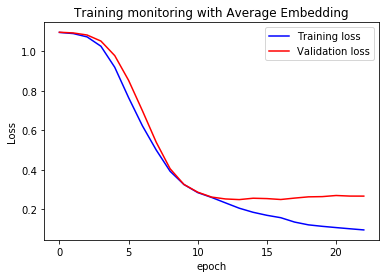


Training loss: [0.11365056600895664, 0.1072935893703263, 0.10124046815063509, 0.09546521768479244]
Validation loss: [0.26425553151279, 0.2699077708999427, 0.2669347843376789, 0.26676996637843287]


In [35]:
# plot the learning process
plot_model_loss(loss_tr, dev_loss, text_to_print = "with Average Embedding", print_last_values=True)

Compute accuracy, precision, recall and F1-Score:

In [36]:
# provided code for preds_te appeared to be wrong
# preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y']) for x,y in zip(X_te,Y_te)]

preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y'][0])+1 for x in X_te]
print('Accuracy:', accuracy_score(Y_te, preds_te))
print('Precision:', precision_score(Y_te, preds_te, average='macro'))
print('Recall:', recall_score(Y_te, preds_te, average='macro'))
print('F1-Score:', f1_score(Y_te, preds_te, average='macro'))

Accuracy: 0.8644444444444445
Precision: 0.8648655570036395
Recall: 0.8644444444444445
F1-Score: 0.8639921854687719


## Choosing model hyperparameters


Embedding size is: 30
Epoch 0: | Training loss: 1.096446, | Validation loss: 1.097390
Epoch 1: | Training loss: 1.090711, | Validation loss: 1.093883
Epoch 2: | Training loss: 1.073783, | Validation loss: 1.083357
Epoch 3: | Training loss: 1.026510, | Validation loss: 1.052694
Epoch 4: | Training loss: 0.919676, | Validation loss: 0.978825
Epoch 5: | Training loss: 0.766042, | Validation loss: 0.853563
Epoch 6: | Training loss: 0.623034, | Validation loss: 0.699538
Epoch 7: | Training loss: 0.500173, | Validation loss: 0.539626
Epoch 8: | Training loss: 0.392758, | Validation loss: 0.405658
Epoch 9: | Training loss: 0.325636, | Validation loss: 0.325959
Epoch 10: | Training loss: 0.284582, | Validation loss: 0.286619
Epoch 11: | Training loss: 0.260104, | Validation loss: 0.261910
Epoch 12: | Training loss: 0.232606, | Validation loss: 0.252399
Convergence at epoch 12 for tolerance = 0.010000 has been reached


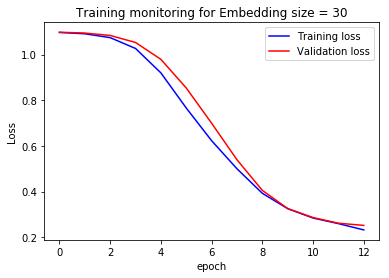


Training loss: [0.3256357622512659, 0.2845815431368538, 0.2601044797733117, 0.23260565620022178]
Validation loss: [0.3259588994312299, 0.286619116275301, 0.2619101575089475, 0.25239897848443915]

Embedding size is: 50
Epoch 0: | Training loss: 1.095589, | Validation loss: 1.096930
Epoch 1: | Training loss: 1.086247, | Validation loss: 1.091053
Epoch 2: | Training loss: 1.059520, | Validation loss: 1.073589
Epoch 3: | Training loss: 0.988496, | Validation loss: 1.025849
Epoch 4: | Training loss: 0.847249, | Validation loss: 0.921682
Epoch 5: | Training loss: 0.684878, | Validation loss: 0.769112
Epoch 6: | Training loss: 0.551786, | Validation loss: 0.606474
Epoch 7: | Training loss: 0.429824, | Validation loss: 0.450720
Epoch 8: | Training loss: 0.344023, | Validation loss: 0.347252
Epoch 9: | Training loss: 0.288240, | Validation loss: 0.292269
Epoch 10: | Training loss: 0.247966, | Validation loss: 0.269061
Epoch 11: | Training loss: 0.213270, | Validation loss: 0.258977
Epoch 12: |

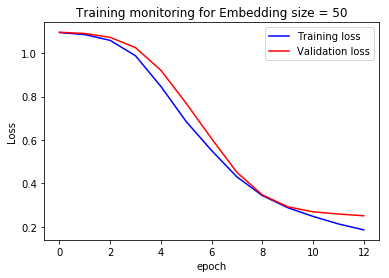


Training loss: [0.28823976577795024, 0.24796564358169065, 0.21327014680602993, 0.1856422372182971]
Validation loss: [0.2922688114249725, 0.26906074141922676, 0.25897743935022355, 0.2508585909323088]

Embedding size is: 100
Epoch 0: | Training loss: 1.092138, | Validation loss: 1.094717
Epoch 1: | Training loss: 1.073322, | Validation loss: 1.082720
Epoch 2: | Training loss: 1.021812, | Validation loss: 1.049429
Epoch 3: | Training loss: 0.905297, | Validation loss: 0.967682
Epoch 4: | Training loss: 0.742745, | Validation loss: 0.830161
Epoch 5: | Training loss: 0.606326, | Validation loss: 0.672266
Epoch 6: | Training loss: 0.482776, | Validation loss: 0.514035
Epoch 7: | Training loss: 0.369357, | Validation loss: 0.379155
Epoch 8: | Training loss: 0.299611, | Validation loss: 0.306425
Epoch 9: | Training loss: 0.253730, | Validation loss: 0.271478
Epoch 10: | Training loss: 0.217043, | Validation loss: 0.256966
Epoch 11: | Training loss: 0.184547, | Validation loss: 0.251048
Conver

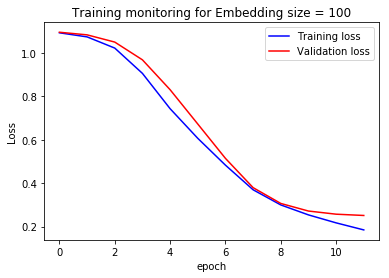


Training loss: [0.29961143366090415, 0.2537298268489014, 0.2170429900083327, 0.1845465013355109]
Validation loss: [0.3064254939709192, 0.27147769904968216, 0.2569657695431468, 0.2510477204801671]

Embedding size is: 300
Epoch 0: | Training loss: 1.079229, | Validation loss: 1.085931
Epoch 1: | Training loss: 1.025855, | Validation loss: 1.051119
Epoch 2: | Training loss: 0.907548, | Validation loss: 0.968199
Epoch 3: | Training loss: 0.726532, | Validation loss: 0.818235
Epoch 4: | Training loss: 0.553646, | Validation loss: 0.630753
Epoch 5: | Training loss: 0.417407, | Validation loss: 0.463510
Epoch 6: | Training loss: 0.331432, | Validation loss: 0.353818
Epoch 7: | Training loss: 0.272894, | Validation loss: 0.302715
Epoch 8: | Training loss: 0.232132, | Validation loss: 0.272257
Epoch 9: | Training loss: 0.193700, | Validation loss: 0.262451
Convergence at epoch 9 for tolerance = 0.010000 has been reached


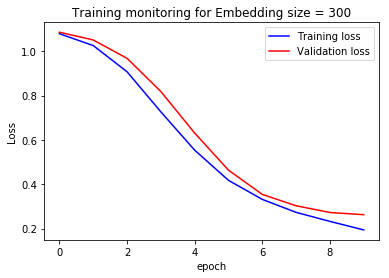


Training loss: [0.33143175132558145, 0.2728944560213631, 0.23213225394362463, 0.19370021413968133]
Validation loss: [0.3538176818711086, 0.302714980761382, 0.27225665556037154, 0.26245077712754256]

Embedding size is: 500
Epoch 0: | Training loss: 1.065623, | Validation loss: 1.078495
Epoch 1: | Training loss: 0.982637, | Validation loss: 1.024206
Epoch 2: | Training loss: 0.823272, | Validation loss: 0.906978
Epoch 3: | Training loss: 0.629825, | Validation loss: 0.725390
Epoch 4: | Training loss: 0.468756, | Validation loss: 0.532069
Epoch 5: | Training loss: 0.360378, | Validation loss: 0.395236
Epoch 6: | Training loss: 0.291956, | Validation loss: 0.323174
Epoch 7: | Training loss: 0.245548, | Validation loss: 0.286081
Epoch 8: | Training loss: 0.207391, | Validation loss: 0.264129
Epoch 9: | Training loss: 0.174104, | Validation loss: 0.254484
Convergence at epoch 9 for tolerance = 0.010000 has been reached


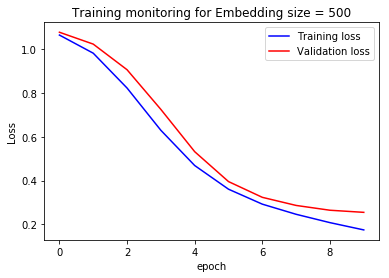


Training loss: [0.2919563531263144, 0.2455478536391527, 0.20739088422326876, 0.17410350847557904]
Validation loss: [0.32317362352674045, 0.2860806059461262, 0.26412877780931754, 0.2544842904315528]


In [37]:
# parameters to vary - embedding_dim, learning rate, tolerance
embedding_size = [30, 50, 100, 300, 500]
lr = 0.01

emb_size_dict = {}
for emb_size in embedding_size:
    print("\nEmbedding size is:",emb_size)
    emb_size_dict[emb_size]={}
    W = network_weights(vocab_size=len(vocab), embedding_dim=emb_size, hidden_dim=[], num_classes=3)
    W, loss_tr, dev_loss = SGD(X_tr, Y_tr, W, X_dev=X_dev, Y_dev=Y_dev, lr=lr, dropout=0.2, freeze_emb=False, tolerance=0.01, epochs=100, print_progress=True)
    plot_model_loss(loss_tr, dev_loss, text_to_print= "for Embedding size = " + str(emb_size), print_last_values=True)
    
    preds_dev = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y'][0])+1 for x in X_dev]
    emb_size_dict[emb_size]['accuracy'] = accuracy_score(Y_dev, preds_dev)
    emb_size_dict[emb_size]['precision'] = precision_score(Y_dev, preds_dev, average='macro')
    emb_size_dict[emb_size]['recall'] = recall_score(Y_dev, preds_dev, average='macro')
    emb_size_dict[emb_size]['f1'] = f1_score(Y_dev, preds_dev, average='macro')
    
    del W  
    gc.collect()

In [38]:
print("Learning rate was:", lr)
embeddings_validation_scores = pd.DataFrame(emb_size_dict).T.reset_index()
embeddings_validation_scores.rename(columns= {"index": "embedding size"}, inplace=True)
embeddings_validation_scores

Learning rate was: 0.01


,embedding size,accuracy,precision,recall,f1
0,30,0.933333,0.934838,0.933333,0.933636
1,50,0.926667,0.928651,0.926667,0.926879
2,100,0.920000,0.923117,0.920000,0.920787
3,300,0.906667,0.912396,0.906667,0.907931
4,500,0.906667,0.912396,0.906667,0.907931



Learning rate is: 0.001
Epoch 0: | Training loss: 1.098414, | Validation loss: 1.098485
Epoch 1: | Training loss: 1.098232, | Validation loss: 1.098402
Epoch 2: | Training loss: 1.098019, | Validation loss: 1.098298
Convergence at epoch 2 for tolerance = 0.010000 has been reached


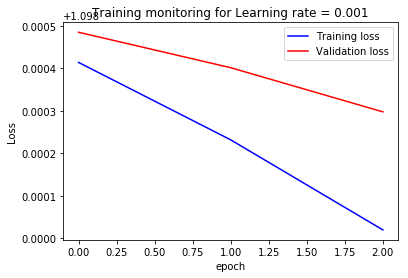


Training loss: [1.0984140713954837, 1.0982315363616366, 1.09801929313451]
Validation loss: [1.0984851458767826, 1.098401573745347, 1.0982975361250964]

Learning rate is: 0.005
Epoch 0: | Training loss: 1.097546, | Validation loss: 1.098058
Epoch 1: | Training loss: 1.095583, | Validation loss: 1.096943
Epoch 2: | Training loss: 1.092011, | Validation loss: 1.094658
Convergence at epoch 2 for tolerance = 0.010000 has been reached


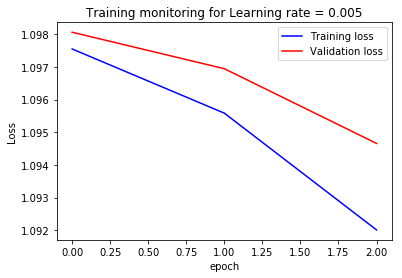


Training loss: [1.0975460101727865, 1.0955829448770589, 1.0920110816593824]
Validation loss: [1.0980579411353726, 1.096942780553813, 1.0946575841675141]

Learning rate is: 0.01
Epoch 0: | Training loss: 1.095589, | Validation loss: 1.096930
Epoch 1: | Training loss: 1.086247, | Validation loss: 1.091053
Epoch 2: | Training loss: 1.059520, | Validation loss: 1.073589
Epoch 3: | Training loss: 0.988496, | Validation loss: 1.025849
Epoch 4: | Training loss: 0.847249, | Validation loss: 0.921682
Epoch 5: | Training loss: 0.684878, | Validation loss: 0.769112
Epoch 6: | Training loss: 0.551786, | Validation loss: 0.606474
Epoch 7: | Training loss: 0.429824, | Validation loss: 0.450720
Epoch 8: | Training loss: 0.344023, | Validation loss: 0.347252
Epoch 9: | Training loss: 0.288240, | Validation loss: 0.292269
Epoch 10: | Training loss: 0.247966, | Validation loss: 0.269061
Epoch 11: | Training loss: 0.213270, | Validation loss: 0.258977
Epoch 12: | Training loss: 0.185642, | Validation lo

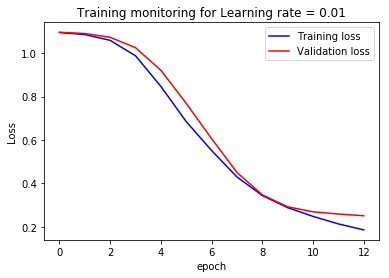


Training loss: [0.28823976577795024, 0.24796564358169065, 0.21327014680602993, 0.1856422372182971]
Validation loss: [0.2922688114249725, 0.26906074141922676, 0.25897743935022355, 0.2508585909323088]

Learning rate is: 0.05
Epoch 0: | Training loss: 0.875067, | Validation loss: 0.944620
Epoch 1: | Training loss: 0.320056, | Validation loss: 0.305991
Epoch 2: | Training loss: 0.151859, | Validation loss: 0.251302
Epoch 3: | Training loss: 0.082310, | Validation loss: 0.245655
Convergence at epoch 3 for tolerance = 0.010000 has been reached


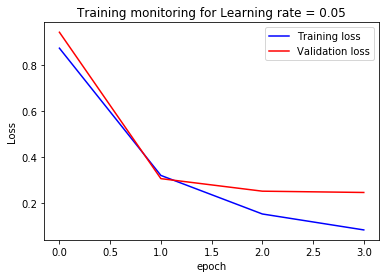


Training loss: [0.8750672065964374, 0.3200561946924177, 0.15185869839267563, 0.082310053786398]
Validation loss: [0.944619679272378, 0.3059909377119443, 0.25130246313191007, 0.24565529780473316]

Learning rate is: 0.1
Epoch 0: | Training loss: 0.338412, | Validation loss: 0.317567
Epoch 1: | Training loss: 0.117891, | Validation loss: 0.266074
Epoch 2: | Training loss: 0.081535, | Validation loss: 0.319916
Epoch 3: | Training loss: 0.032681, | Validation loss: 0.341998
Epoch 4: | Training loss: 0.028102, | Validation loss: 0.413342
Epoch 5: | Training loss: 0.021426, | Validation loss: 0.400203
Epoch 6: | Training loss: 0.021042, | Validation loss: 0.469822
Epoch 7: | Training loss: 0.017321, | Validation loss: 0.503672
Epoch 8: | Training loss: 0.016900, | Validation loss: 0.526816
Epoch 9: | Training loss: 0.019860, | Validation loss: 0.539094
Epoch 10: | Training loss: 0.012346, | Validation loss: 0.602860
Epoch 11: | Training loss: 0.008806, | Validation loss: 0.636910
Epoch 12: |

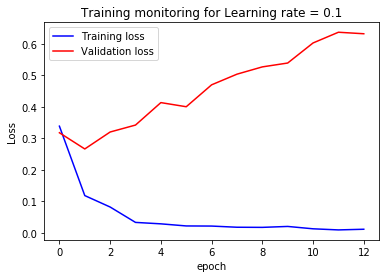


Training loss: [0.019860427430309104, 0.012346024013292491, 0.008806265499521094, 0.01094617842214386]
Validation loss: [0.5390943496608005, 0.6028604952130127, 0.6369098289850857, 0.6321268340159316]


In [39]:
learning_rate = [0.001,0.005, 0.01, 0.05, 0.1]
learn_rate_dict = {}
emb_size = 50

for lr in learning_rate:
    print("\nLearning rate is:",lr)
    learn_rate_dict[lr]={}
    W = network_weights(vocab_size=len(vocab), embedding_dim=emb_size, hidden_dim=[], num_classes=3)
    W, loss_tr, dev_loss = SGD(X_tr, Y_tr, W, X_dev=X_dev, Y_dev=Y_dev, lr=lr, dropout=0.2, freeze_emb=False, tolerance=0.01, epochs=100, print_progress=True)
    plot_model_loss(loss_tr, dev_loss, text_to_print= "for Learning rate = " + str(lr), print_last_values=True)
    
    preds_dev = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y'][0])+1 for x in X_dev]
    learn_rate_dict[lr]['accuracy'] = accuracy_score(Y_dev, preds_dev)
    learn_rate_dict[lr]['precision'] = precision_score(Y_dev, preds_dev, average='macro')
    learn_rate_dict[lr]['recall'] = recall_score(Y_dev, preds_dev, average='macro')
    learn_rate_dict[lr]['f1'] = f1_score(Y_dev, preds_dev, average='macro')
    
    del W  
    gc.collect()

In [40]:
print("Embedding size was: ", emb_size)
learning_rates_validation_scores = pd.DataFrame(learn_rate_dict).T.reset_index()
learning_rates_validation_scores.rename(columns= {"index": "learning_rate"}, inplace=True)
learning_rates_validation_scores

Embedding size was:  50


,learning_rate,accuracy,precision,recall,f1
0,0.001,0.380000,0.388362,0.380000,0.376560
1,0.005,0.673333,0.671573,0.673333,0.664086
2,0.010,0.926667,0.928651,0.926667,0.926879
3,0.050,0.920000,0.922091,0.920000,0.920209
4,0.100,0.866667,0.872007,0.866667,0.868135


As it can be seen from the graphs, the only reasonable variant is learning_rate=0.01, 
as lower learning rates shows underfitting, and hiher values lead to overfitting.

# Use Pre-trained Embeddings

In [41]:
def get_glove_embeddings(f_zip, f_txt, word2id, emb_size=300):
    
    w_emb = np.zeros((len(word2id), emb_size))
    
    with zipfile.ZipFile(f_zip) as z:
        with z.open(f_txt) as f:
            for line in f:
                line = line.decode('utf-8')
                word = line.split()[0]
                     
                if word in vocab:
                    emb = np.array(line.strip('\n').split()[1:]).astype(np.float32)
                    w_emb[word2id[word]] +=emb
    return w_emb

In [42]:
import time

In [43]:
%%time
# That is the slowest stage in the whole code
word2id = dict_word_id
w_glove = get_glove_embeddings("glove.840B.300d.zip","glove.840B.300d.txt", word2id)

CPU times: user 2min 30s, sys: 3.59 s, total: 2min 33s
Wall time: 2min 41s


In [44]:
w_glove.shape

(8931, 300)

First, initialise the weights of your network using the `network_weights` function. Second, replace the weigths of the embedding matrix with `w_glove`. Finally, train the network by freezing the embedding weights: 

In [45]:
# initialise the weights,  replace the embedding matrix with w_glove.
# train the network by freezing the embedding weights
W = network_weights(vocab_size=len(vocab), embedding_dim=w_glove.shape[1], hidden_dim=[], num_classes=3)
W[0].shape 

(8931, 300)

In [46]:
W[0] = w_glove

In [47]:
W, loss_tr, dev_loss = SGD(X_tr, Y_tr, W, X_dev=X_dev, Y_dev=Y_dev, lr=0.01, dropout=0.2, freeze_emb=True, 
                           tolerance=0.001, epochs=100, print_progress=True)

Epoch 0: | Training loss: 1.051091, | Validation loss: 1.052847
Epoch 1: | Training loss: 0.946273, | Validation loss: 0.941078
Epoch 2: | Training loss: 0.560805, | Validation loss: 0.573918
Epoch 3: | Training loss: 0.383952, | Validation loss: 0.360303
Epoch 4: | Training loss: 0.311401, | Validation loss: 0.250150
Epoch 5: | Training loss: 0.267936, | Validation loss: 0.204408
Epoch 6: | Training loss: 0.242371, | Validation loss: 0.171712
Epoch 7: | Training loss: 0.206567, | Validation loss: 0.166937
Epoch 8: | Training loss: 0.188801, | Validation loss: 0.150169
Epoch 9: | Training loss: 0.159503, | Validation loss: 0.144048
Epoch 10: | Training loss: 0.139433, | Validation loss: 0.143646
Convergence at epoch 10 for tolerance = 0.001000 has been reached


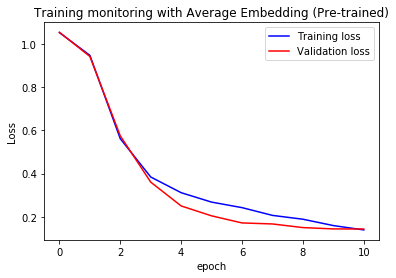


Training loss: [0.20656685528981764, 0.18880087666461595, 0.15950344845903516, 0.13943268376117235]
Validation loss: [0.16693744535923324, 0.15016891725362036, 0.14404829815130157, 0.14364625814155277]


In [48]:
plot_model_loss(loss_tr, dev_loss, text_to_print = "with Average Embedding (Pre-trained)", print_last_values=True)

In [49]:
preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y'][0])+1 for x in X_te]
print('Accuracy:', accuracy_score(Y_te,preds_te))
print('Precision:', precision_score(Y_te,preds_te,average='macro'))
print('Recall:', recall_score(Y_te,preds_te,average='macro'))
print('F1-Score:', f1_score(Y_te,preds_te,average='macro'))

Accuracy: 0.8944444444444445
Precision: 0.8943436515170006
Recall: 0.8944444444444444
F1-Score: 0.894158300265336


**Observation:** network with gloves leads to better results

## Choosing model hyperparameters


Learning rate is: 0.001
Epoch 0: | Training loss: 0.873112, | Validation loss: 0.924134
Epoch 1: | Training loss: 0.677974, | Validation loss: 0.746107
Epoch 2: | Training loss: 0.543808, | Validation loss: 0.619080
Epoch 3: | Training loss: 0.451602, | Validation loss: 0.527331
Epoch 4: | Training loss: 0.385058, | Validation loss: 0.458088
Epoch 5: | Training loss: 0.336792, | Validation loss: 0.407238
Epoch 6: | Training loss: 0.304118, | Validation loss: 0.366465
Epoch 7: | Training loss: 0.274010, | Validation loss: 0.334823
Epoch 8: | Training loss: 0.255963, | Validation loss: 0.308928
Epoch 9: | Training loss: 0.238755, | Validation loss: 0.287850
Epoch 10: | Training loss: 0.224407, | Validation loss: 0.270322
Epoch 11: | Training loss: 0.213364, | Validation loss: 0.257134
Epoch 12: | Training loss: 0.204286, | Validation loss: 0.244458
Epoch 13: | Training loss: 0.197684, | Validation loss: 0.235107
Convergence at epoch 13 for tolerance = 0.010000 has been reached


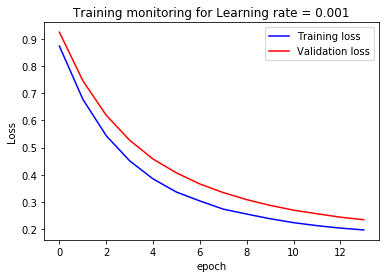


Training loss: [0.2244068494925936, 0.2133641522162587, 0.20428632701395508, 0.19768393509067142]
Validation loss: [0.27032206820150245, 0.25713405916379656, 0.24445807739693567, 0.23510709972747426]

Learning rate is: 0.01
Epoch 0: | Training loss: 0.221658, | Validation loss: 0.264494
Epoch 1: | Training loss: 0.177063, | Validation loss: 0.196183
Epoch 2: | Training loss: 0.153220, | Validation loss: 0.175760
Epoch 3: | Training loss: 0.135980, | Validation loss: 0.169106
Convergence at epoch 3 for tolerance = 0.010000 has been reached


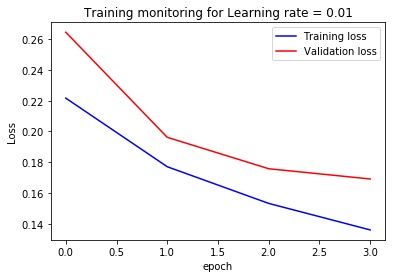


Training loss: [0.22165764553566916, 0.17706280518517048, 0.15321960954565805, 0.13598003286274796]
Validation loss: [0.26449408056355156, 0.19618262831174, 0.17575983917667007, 0.1691059806223566]

Learning rate is: 0.1
Epoch 0: | Training loss: 0.068361, | Validation loss: 0.185456
Epoch 1: | Training loss: 0.037464, | Validation loss: 0.273685
Epoch 2: | Training loss: 0.017309, | Validation loss: 0.264759
Convergence at epoch 2 for tolerance = 0.010000 has been reached


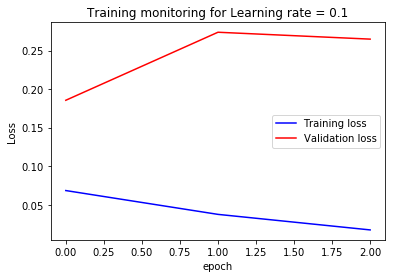


Training loss: [0.06836124108916317, 0.03746433805990011, 0.017308729760945715]
Validation loss: [0.18545610778828703, 0.2736848879356728, 0.26475897331984255]


In [50]:
learning_rate = [0.001, 0.01, 0.1]
learn_rate_dict_glove = {}
emb_size = 50

for lr in learning_rate:
    print("\nLearning rate is:",lr)
    learn_rate_dict_glove[lr]={}
    W = network_weights(vocab_size=len(vocab), embedding_dim=w_glove.shape[1], hidden_dim=[], num_classes=3)
    W[0] = w_glove
    W, loss_tr, dev_loss = SGD(X_tr, Y_tr, W, X_dev=X_dev, Y_dev=Y_dev, lr=lr, dropout=0.2, freeze_emb=True, tolerance=0.01, epochs=100, print_progress=True)
    plot_model_loss(loss_tr, dev_loss, text_to_print= "for Learning rate = " + str(lr), print_last_values=True)
    
    preds_dev = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y'][0])+1 for x in X_dev]
    learn_rate_dict_glove[lr]['accuracy'] = accuracy_score(Y_dev, preds_dev)
    learn_rate_dict_glove[lr]['precision'] = precision_score(Y_dev, preds_dev, average='macro')
    learn_rate_dict_glove[lr]['recall'] = recall_score(Y_dev, preds_dev, average='macro')
    learn_rate_dict_glove[lr]['f1'] = f1_score(Y_dev, preds_dev, average='macro')
    
    del W  
    gc.collect()

In [51]:
glove_lr_validation_scores = pd.DataFrame(learn_rate_dict_glove).T.reset_index()
glove_lr_validation_scores.rename(columns= {"index": "learning_rate"}, inplace=True)
glove_lr_validation_scores

,learning_rate,accuracy,precision,recall,f1
0,0.001,0.953333,0.955192,0.953333,0.952907
1,0.010,0.953333,0.953992,0.953333,0.953097
2,0.100,0.920000,0.921306,0.920000,0.920231


**Conclusion:** Though the table with results presents almost similar score, 
training and validation curves shows only one acceptable variant for this network which is lr=0.001

# Extend to support deeper architectures (Bonus)

Extend the network to support back-propagation for more hidden layers. You need to modify the `backward_pass` function above to compute gradients and update the weights between intermediate hidden layers. Finally, train and evaluate a network with a deeper architecture. 

In [52]:
W = network_weights(vocab_size=len(vocab), embedding_dim=w_glove.shape[1], hidden_dim=[10], num_classes=3)
W[0] = w_glove

W, loss_tr, dev_loss = SGD(X_tr, Y_tr, W, X_dev = X_dev, Y_dev = Y_dev, lr = 0.01, dropout = 0.3, freeze_emb = True, 
                           tolerance = 0.001, epochs = 100, print_progress = True)

Epoch 0: | Training loss: 1.017612, | Validation loss: 1.029205
Epoch 1: | Training loss: 0.918199, | Validation loss: 0.948852
Epoch 2: | Training loss: 0.787121, | Validation loss: 0.843330
Epoch 3: | Training loss: 0.645670, | Validation loss: 0.717640
Epoch 4: | Training loss: 0.526156, | Validation loss: 0.588638
Epoch 5: | Training loss: 0.439527, | Validation loss: 0.472154
Epoch 6: | Training loss: 0.370551, | Validation loss: 0.384074
Epoch 7: | Training loss: 0.319461, | Validation loss: 0.302999
Epoch 8: | Training loss: 0.306519, | Validation loss: 0.263607
Epoch 9: | Training loss: 0.293506, | Validation loss: 0.255894
Epoch 10: | Training loss: 0.288066, | Validation loss: 0.273254
Epoch 11: | Training loss: 0.292779, | Validation loss: 0.279839
Epoch 12: | Training loss: 0.292955, | Validation loss: 0.294357
Epoch 13: | Training loss: 0.299162, | Validation loss: 0.308015
Epoch 14: | Training loss: 0.310282, | Validation loss: 0.309372
Epoch 15: | Training loss: 0.302595

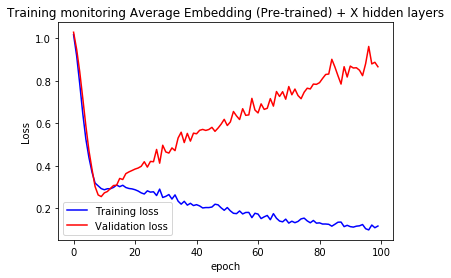


Training loss: [0.09910883944948035, 0.12208274436159212, 0.10939538290610355, 0.11742995767609471]
Validation loss: [0.9623380768278675, 0.8801535240965014, 0.8879328188770566, 0.8667793850739317]


In [53]:
plot_model_loss(loss_tr, dev_loss, text_to_print = "Average Embedding (Pre-trained) + X hidden layers", print_last_values=True)

In [54]:
preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y'][0])+1 for x in X_te]
print('Accuracy:', accuracy_score(Y_te,preds_te))
print('Precision:', precision_score(Y_te,preds_te,average='macro'))
print('Recall:', recall_score(Y_te,preds_te,average='macro'))
print('F1-Score:', f1_score(Y_te,preds_te,average='macro'))

Accuracy: 0.8466666666666667
Precision: 0.8596151760527383
Recall: 0.8466666666666667
F1-Score: 0.8463941682609833


In [55]:
del W  
gc.collect()

2467


Dimension of 1 hidden layer: 2
Epoch 0: | Training loss: 1.085754, | Validation loss: 1.087759
Epoch 1: | Training loss: 1.074404, | Validation loss: 1.078682
Epoch 2: | Training loss: 1.060436, | Validation loss: 1.066768
Epoch 3: | Training loss: 1.044767, | Validation loss: 1.052503
Epoch 4: | Training loss: 1.027096, | Validation loss: 1.036030
Epoch 5: | Training loss: 1.006602, | Validation loss: 1.017487
Epoch 6: | Training loss: 0.985208, | Validation loss: 0.999251
Epoch 7: | Training loss: 0.964920, | Validation loss: 0.982222
Epoch 8: | Training loss: 0.949502, | Validation loss: 0.970937
Epoch 9: | Training loss: 0.933718, | Validation loss: 0.962094
Epoch 10: | Training loss: 0.905931, | Validation loss: 0.939590
Epoch 11: | Training loss: 0.909288, | Validation loss: 0.959207
Epoch 12: | Training loss: 0.903381, | Validation loss: 0.963470
Epoch 13: | Training loss: 0.893927, | Validation loss: 0.965771
Epoch 14: | Training loss: 0.895050, | Validation loss: 0.978963
Epo

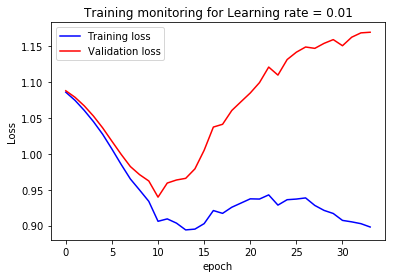


Training loss: [0.907186277461733, 0.9051515643664629, 0.9026286875684953, 0.8979916849999997]
Validation loss: [1.1505057872804312, 1.1623669812442796, 1.1684053959445402, 1.1692782516162865]

Dimension of 1 hidden layer: 3


/Users/Marina/anaconda3/envs/myspark/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 0: | Training loss: 1.026207, | Validation loss: 1.062192
Epoch 1: | Training loss: 1.000012, | Validation loss: 1.046781
Epoch 2: | Training loss: 0.986326, | Validation loss: 1.034343
Epoch 3: | Training loss: 0.969590, | Validation loss: 1.018478
Epoch 4: | Training loss: 0.951569, | Validation loss: 1.000047
Epoch 5: | Training loss: 0.934163, | Validation loss: 0.979496
Epoch 6: | Training loss: 0.918159, | Validation loss: 0.958211
Epoch 7: | Training loss: 0.904449, | Validation loss: 0.942162
Epoch 8: | Training loss: 0.892308, | Validation loss: 0.924690
Epoch 9: | Training loss: 0.881222, | Validation loss: 0.907387
Epoch 10: | Training loss: 0.872817, | Validation loss: 0.893572
Epoch 11: | Training loss: 0.866034, | Validation loss: 0.878569
Epoch 12: | Training loss: 0.859509, | Validation loss: 0.871610
Epoch 13: | Training loss: 0.855427, | Validation loss: 0.862926
Epoch 14: | Training loss: 0.851664, | Validation loss: 0.856213
Epoch 15: | Training loss: 0.849670

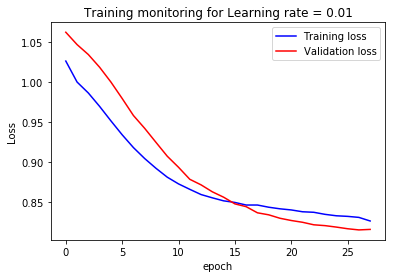


Training loss: [0.8330040869848141, 0.8322727750543261, 0.8309812009347061, 0.8264968921744649]
Validation loss: [0.8188803629651709, 0.8168186991409757, 0.8153506333839222, 0.8159924831097384]

Dimension of 1 hidden layer: 5
Epoch 0: | Training loss: 0.854632, | Validation loss: 0.921192
Epoch 1: | Training loss: 0.703860, | Validation loss: 0.800270
Epoch 2: | Training loss: 0.612590, | Validation loss: 0.710555
Epoch 3: | Training loss: 0.573560, | Validation loss: 0.660775
Epoch 4: | Training loss: 0.557228, | Validation loss: 0.634035
Epoch 5: | Training loss: 0.550121, | Validation loss: 0.620838
Epoch 6: | Training loss: 0.548572, | Validation loss: 0.611218
Epoch 7: | Training loss: 0.550576, | Validation loss: 0.612835
Epoch 8: | Training loss: 0.551252, | Validation loss: 0.610564
Epoch 9: | Training loss: 0.549650, | Validation loss: 0.608548
Epoch 10: | Training loss: 0.551568, | Validation loss: 0.603196
Epoch 11: | Training loss: 0.549294, | Validation loss: 0.595532
Epo

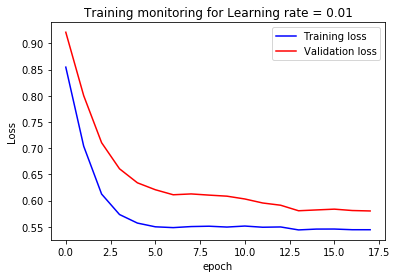


Training loss: [0.5457747354809198, 0.5458531971753456, 0.5445646411061611, 0.5445438289305518]
Validation loss: [0.5822954401990043, 0.5838025221437746, 0.5811784322089755, 0.5803365508881781]

Dimension of 1 hidden layer: 10
Epoch 0: | Training loss: 0.097687, | Validation loss: 0.343111
Epoch 1: | Training loss: 0.104722, | Validation loss: 0.432864
Epoch 2: | Training loss: 0.116766, | Validation loss: 0.463013
Epoch 3: | Training loss: 0.111923, | Validation loss: 0.568234
Epoch 4: | Training loss: 0.103321, | Validation loss: 0.580114
Epoch 5: | Training loss: 0.118809, | Validation loss: 0.570405
Epoch 6: | Training loss: 0.123986, | Validation loss: 0.570895
Convergence at epoch 6 for tolerance = 0.001000 has been reached


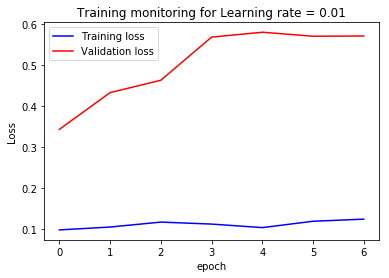


Training loss: [0.11192266346589685, 0.10332083962287462, 0.11880858781998567, 0.12398584678681729]
Validation loss: [0.5682341775198106, 0.5801138179270549, 0.5704045425778161, 0.5708953732949404]


In [56]:
hid_dim = [2,3,5,10]
hidden_dict_glove = {}
lr = 0.01 # the  best value for the case of pre-trained model
emb_size = w_glove.shape[1]

for hd in hid_dim:
    print("\nDimension of 1 hidden layer:",hd)
    hidden_dict_glove[hd]={}
    W = network_weights(vocab_size=len(vocab), embedding_dim=emb_size, hidden_dim=[hd], num_classes=3)
    W[0] = w_glove
    W, loss_tr, dev_loss = SGD(X_tr, Y_tr, W, X_dev=X_dev, Y_dev=Y_dev, lr=lr, dropout=0.2, freeze_emb=True, tolerance=0.001, epochs=100, print_progress=True)
    plot_model_loss(loss_tr, dev_loss, text_to_print= "for Learning rate = " + str(lr), print_last_values=True)
    
    preds_dev = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y'][0])+1 for x in X_dev]
    hidden_dict_glove[hd]['accuracy'] = accuracy_score(Y_dev, preds_dev)
    hidden_dict_glove[hd]['precision'] = precision_score(Y_dev, preds_dev, average='macro')
    hidden_dict_glove[hd]['recall'] = recall_score(Y_dev, preds_dev, average='macro')
    hidden_dict_glove[hd]['f1'] = f1_score(Y_dev, preds_dev, average='macro')
    
    del W  
    gc.collect()

In [57]:
hidden_dict_glove_scores = pd.DataFrame(hidden_dict_glove).T.reset_index()
hidden_dict_glove_scores.rename(columns= {"index": "dimension_1_hidden"}, inplace=True)
hidden_dict_glove_scores

,dimension_1_hidden,accuracy,precision,recall,f1
0,2,0.333333,0.111111,0.333333,0.166667
1,3,0.626667,0.453318,0.626667,0.515894
2,5,0.886667,0.907213,0.886667,0.886309
3,10,0.893333,0.902049,0.893333,0.895062


## Full Results

In [58]:
# the best parameters for Average Embedding
lr = 0.01
emb_size = 50

W = network_weights(vocab_size=len(vocab), embedding_dim=emb_size, hidden_dim=[], num_classes=3)
W, loss_tr, dev_loss = SGD(X_tr, Y_tr, W, X_dev=X_dev, Y_dev=Y_dev, lr=lr, dropout=0.2, freeze_emb=False, tolerance=0.01, epochs=100, print_progress=False)
print("\nResults for Average Embedding\n")
preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y'][0])+1 for x in X_te]
print('Accuracy:', accuracy_score(Y_te,preds_te))
print('Precision:', precision_score(Y_te,preds_te,average='macro'))
print('Recall:', recall_score(Y_te,preds_te,average='macro'))
print('F1-Score:', f1_score(Y_te,preds_te,average='macro'))
del W  
gc.collect()

Convergence at epoch 12 for tolerance = 0.010000 has been reached

Results for Average Embedding

Accuracy: 0.8633333333333333
Precision: 0.8640704956163893
Recall: 0.8633333333333333
F1-Score: 0.8627599715099715


0

In [59]:
# the best parameters for Average Embedding (pre-trained)
lr = 0.001
emb_size = w_glove.shape[1]

W = network_weights(vocab_size=len(vocab), embedding_dim=emb_size, hidden_dim=[], num_classes=3)
W[0] = w_glove
W, loss_tr, dev_loss = SGD(X_tr, Y_tr, W, X_dev=X_dev, Y_dev=Y_dev, lr=lr, dropout=0.2, freeze_emb=True, tolerance=0.01, epochs=100, print_progress=False)
print("\nResults for Average Embedding (pre-trained)\n")
preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y'][0])+1 for x in X_te]
print('Accuracy:', accuracy_score(Y_te,preds_te))
print('Precision:', precision_score(Y_te,preds_te,average='macro'))
print('Recall:', recall_score(Y_te,preds_te,average='macro'))
print('F1-Score:', f1_score(Y_te,preds_te,average='macro'))
del W  
gc.collect()

Convergence at epoch 4 for tolerance = 0.010000 has been reached

Results for Average Embedding (pre-trained)

Accuracy: 0.8666666666666667
Precision: 0.8686509510115233
Recall: 0.8666666666666666
F1-Score: 0.8666446515312874


0

In [60]:
# the best parameters for Average Embedding (Pre-trained) + 1 hidden layer

hidden_1_dim= 10 #gave 0.90 on development set and showed good

W = network_weights(vocab_size=len(vocab), embedding_dim=w_glove.shape[1], hidden_dim=[hidden_1_dim], num_classes=3)
W[0] = w_glove

W, loss_tr, dev_loss = SGD(X_tr, Y_tr, W, X_dev = X_dev, Y_dev = Y_dev, lr = 0.01, dropout = 0.3, freeze_emb = True, 
                           tolerance = 0.001, epochs = 100, print_progress = False)

print("\nResults for Average Embedding (Pre-trained) + 1 hidden layer\n")
preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y'][0])+1 for x in X_te]
print('Accuracy:', accuracy_score(Y_te,preds_te))
print('Precision:', precision_score(Y_te,preds_te,average='macro'))
print('Recall:', recall_score(Y_te,preds_te,average='macro'))
print('F1-Score:', f1_score(Y_te,preds_te,average='macro'))
del W  
gc.collect()

Convergence at epoch 32 for tolerance = 0.001000 has been reached

Results for Average Embedding (Pre-trained) + 1 hidden layer

Accuracy: 0.8555555555555555
Precision: 0.8635118739785472
Recall: 0.8555555555555555
F1-Score: 0.8556616715377735


0

Final results:

| Model | Precision  | Recall  | F1-Score  | Accuracy
|:-:|:-:|:-:|:-:|:-:|
| Average Embedding  | 0.8640|  0.8633 | 0.8628 |0.8633 |
| Average Embedding (Pre-trained)  |  0.8687 | 0.8667  |  0.8666  |0.8676
| Average Embedding (Pre-trained) + X hidden layers (BONUS)   |  0.8635 |0.8556  |0.8557   |0.8556   |

**Conclusion:** The best model appeared to Average embedding with usage of pretrained embeddings. Deeper neural network turned out to be very prone to overfitting, i.e. showing the best results on the validation sets among all three models it lead to the worst results on the unseen test set. At the same time, the values of all the metrics for all thrwee model are very close to each other.